In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import yfinance as yf
import hvplot.pandas
from pathlib import Path
from finta import TA
import matplotlib.pyplot as plt
import quantstats as qs
import itertools
from IPython.display import clear_output

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
### Quant framework 3 x 3 x 3

#     Intraday   >>Swing<<    >>Position<<

#     Earnings     Event      >>TA<<

#   >>Delta<<      Theta        Vega

# Project 2 scope is focused on Swing and Position timeframe, while relying on TA
# to determine signals. Option strategies are not used.

### Technical goal:

# Automate creation and testing of new trading algorithms based on our framework

### Plan:

# 1. Pull the data: ohlc + volume ✓
# 2. Integrate Finta with our data ✓
# 3. Determine trading signals for testable indicators (crossovers, etc.)✓
# 4. Test the strategy on data of 2017 - 2019 
# 5. Automate testing of different combinations of strategies
# 6. Train ML algorithms on best performing strategies
# 7. Deploy trained ML algorithms and test performance on 2020-2023 data

In [5]:
sqrt = np.sqrt(252)
trading_days_year = 252
total_days_year = 365
thirty_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 30)).date()
ten_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 10)).date()
five_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 5)).date()
three_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 3)).date()
one_year = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 1)).date()
six_months = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year / 2)).date()
yesterday = (pd.Timestamp.today() - pd.Timedelta(days = 1)).date()
sixty_days = (pd.Timestamp.today() - pd.Timedelta(days = 59)).date()
# Portfolio vars

share_size = 100
initial_capital = 100000

# Optionable stocks 
optionable_stocks_path = Path('./Resources/optionable_stocks.csv')
with open(optionable_stocks_path, 'r') as file:
    optionable_stocks = file.read()
optionable_stocks = optionable_stocks.replace('\n', ' ')

# 1. Pull the data: ohlc + volume

In [99]:
def get_data(interval, start, end, seg_window = 21):
    yf_df = yf.Tickers(optionable_stocks)
    df_full =yf_df.history(start = start, end = end, interval= interval)
    stocks = df_full[['Open', 'Close', 'High', 'Low', 'Volume']]
    
    if interval == '5m':
        sqrt_val = 252 * 78 
    elif interval == '15m':
        sqrt_val = 252 * 26  
    elif interval == '30m':
        sqrt_val = 252 * 13 
    elif interval == '1h':
        sqrt_val = 252 * 6.5
    elif interval == '1d':
        sqrt_val = 252
    elif interval == '1wk':
        sqrt_val = 52
        
    stock_names = stocks.columns.get_level_values(1).unique().tolist()

    cumulative_return_column = pd.MultiIndex.from_product([['Rolling_Cumulative_Return'], stock_names])
    volatility_column = pd.MultiIndex.from_product([['Rolling_Volatility'], stock_names])
    sharpe_column = pd.MultiIndex.from_product([['Rolling_Sharpe'], stock_names])
    rank_column = pd.MultiIndex.from_product([['Rank_Sharpe'], stock_names])
    
    df_cumulative_return = pd.DataFrame(0.0, index = stocks.index , columns = cumulative_return_column)
    df_volatility = pd.DataFrame(0.0, index = stocks.index , columns = volatility_column )
    df_sharpe = pd.DataFrame(0.0, index = stocks.index , columns = sharpe_column)
    df_rank = pd.DataFrame(0.0, index = stocks.index , columns = sharpe_column)
    
    for stock in stock_names:
        mask = stocks.columns.get_level_values(1) == stock
        data = stocks.loc[:, mask]
        data.columns = data.columns.droplevel(1)
        close = data['Close']
        returns = data['Close'].pct_change()
        df_cumulative_return[('Rolling_Cumulative_Return', stock)] = (1 + returns).rolling(window=seg_window).apply(lambda x: x.prod())
        df_volatility[('Rolling_Volatility', stock)] = returns.rolling(window=seg_window).std() * np.sqrt(sqrt_val)
        df_sharpe[('Rolling_Sharpe', stock)] = (returns.rolling(window=seg_window).mean() * sqrt_val) / df_volatility[('Rolling_Volatility', stock)]
        
    def rank_row(row):
        return row.rank(ascending=False)

    df_rank = df_sharpe.apply(rank_row, axis=1)
    df_rank.columns = rank_column
    
    final_df = pd.concat([stocks, df_rank], axis = 1)
    
    return final_df


In [100]:
def get_individual_stock(stock, stocks):
    mask = stocks.columns.get_level_values(1) == stock
    data = stocks.loc[:, mask]
    data.columns = data.columns.droplevel(1)
    data.dropna(inplace = True)
    return data

In [101]:
# Pulls data for different time intervals. YF only provides last 60 days worth of intraday data

stocks_1wk = get_data('1wk', '2017-01-01', yesterday)
stocks_1d = get_data('1d', '2017-01-01', yesterday)
stocks_1h = get_data('1h', sixty_days, yesterday)
stocks_30m = get_data('30m', sixty_days, yesterday)
stocks_15m = get_data('15m', sixty_days, yesterday)
stocks_5m = get_data('5m', sixty_days, yesterday)

# gets valid stock names that we can iterate over in Tester()
stock_names = stocks_1d.columns.get_level_values(1).unique().tolist()

[*********************100%***********************]  95 of 95 completed
[*********************100%***********************]  95 of 95 completed
[*********************100%***********************]  95 of 95 completed
[*********************100%***********************]  95 of 95 completed
[*********************100%***********************]  95 of 95 completed
[*********************100%***********************]  95 of 95 completed


# 2. Integrate Finta with our data 

## Getting indicators demo
### Once we have the finalized list of indicators, I will combine them into one function

<Axes: xlabel='Date'>

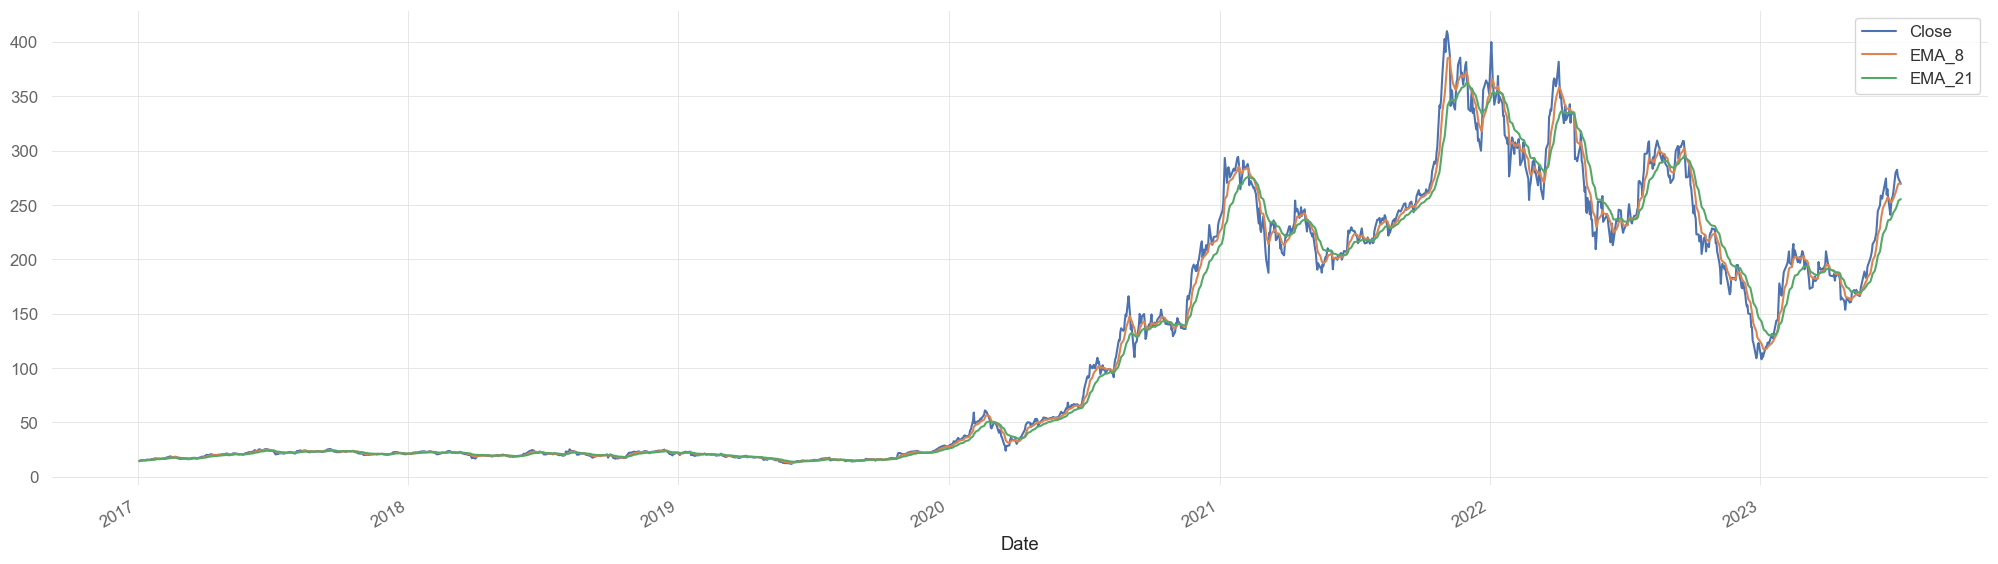

In [8]:
# EMA
short_window = 8
long_window = 21
df = get_individual_stock('TSLA', stocks_1d)
df[f'EMA_{short_window}'] = TA.EMA(df, short_window)
df[f'EMA_{long_window}'] = TA.EMA(df, long_window)
df[['Close', 'EMA_8', 'EMA_21']].plot(figsize = (25,7))

<Axes: xlabel='Date'>

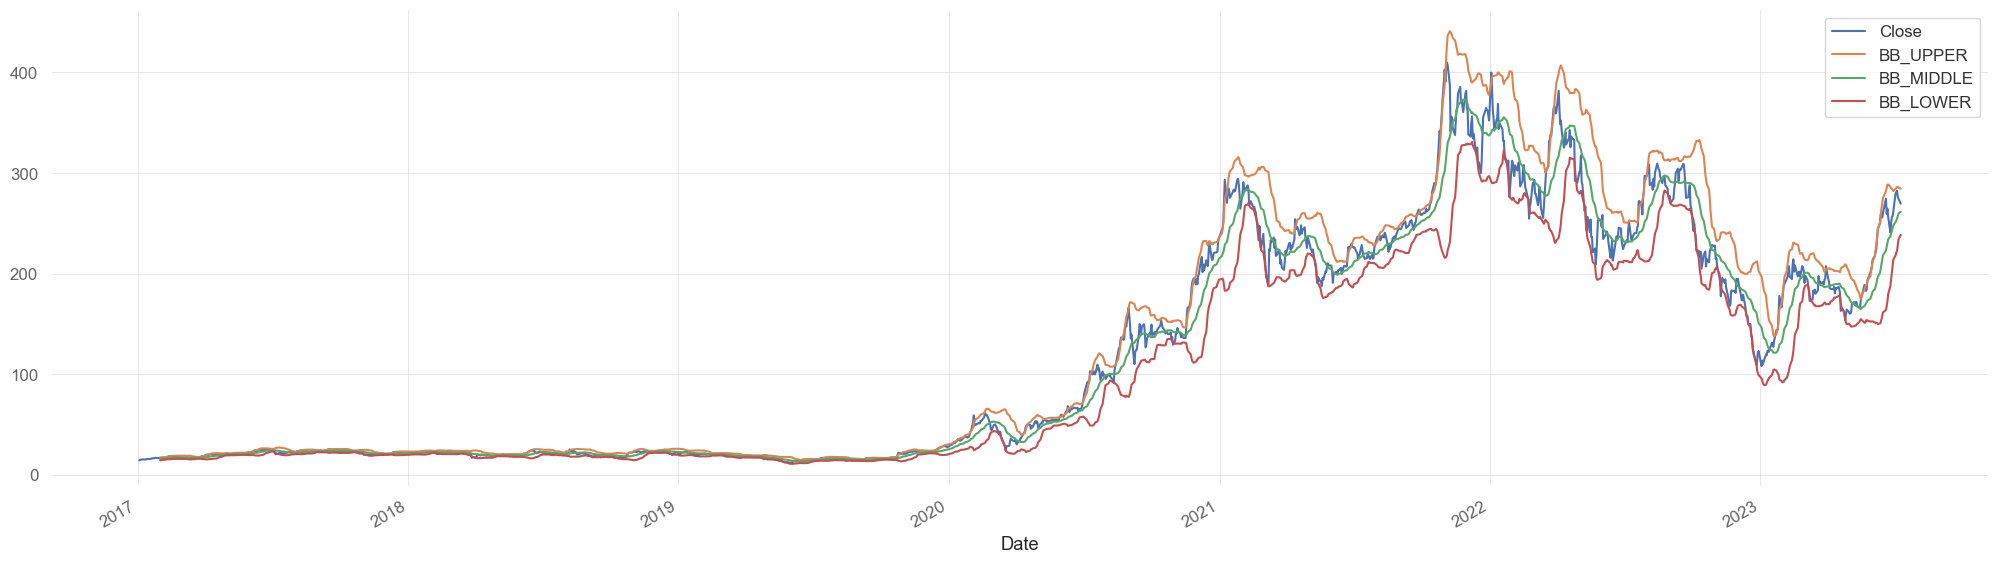

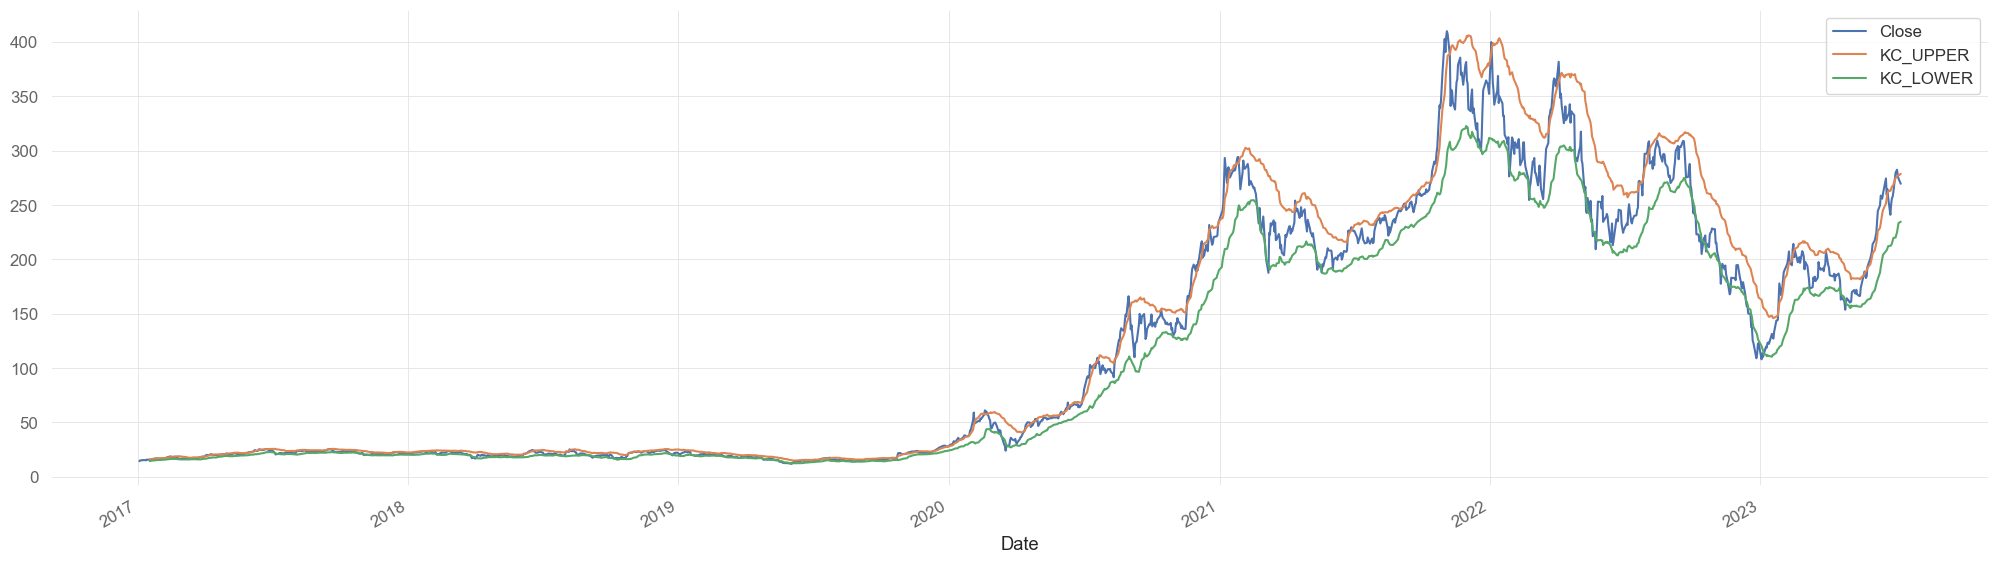

In [9]:
# BBANDS
df[['BB_UPPER','BB_MIDDLE','BB_LOWER']] = TA.BBANDS(df)
df[['Close', 'BB_UPPER','BB_MIDDLE','BB_LOWER']].plot(figsize = (25,7))

# Keltner Channels
df[['KC_UPPER', 'KC_LOWER']] = TA.KC(df)
df[['Close', 'KC_UPPER', 'KC_LOWER']].plot(figsize = (25,7))

<Axes: xlabel='Date'>

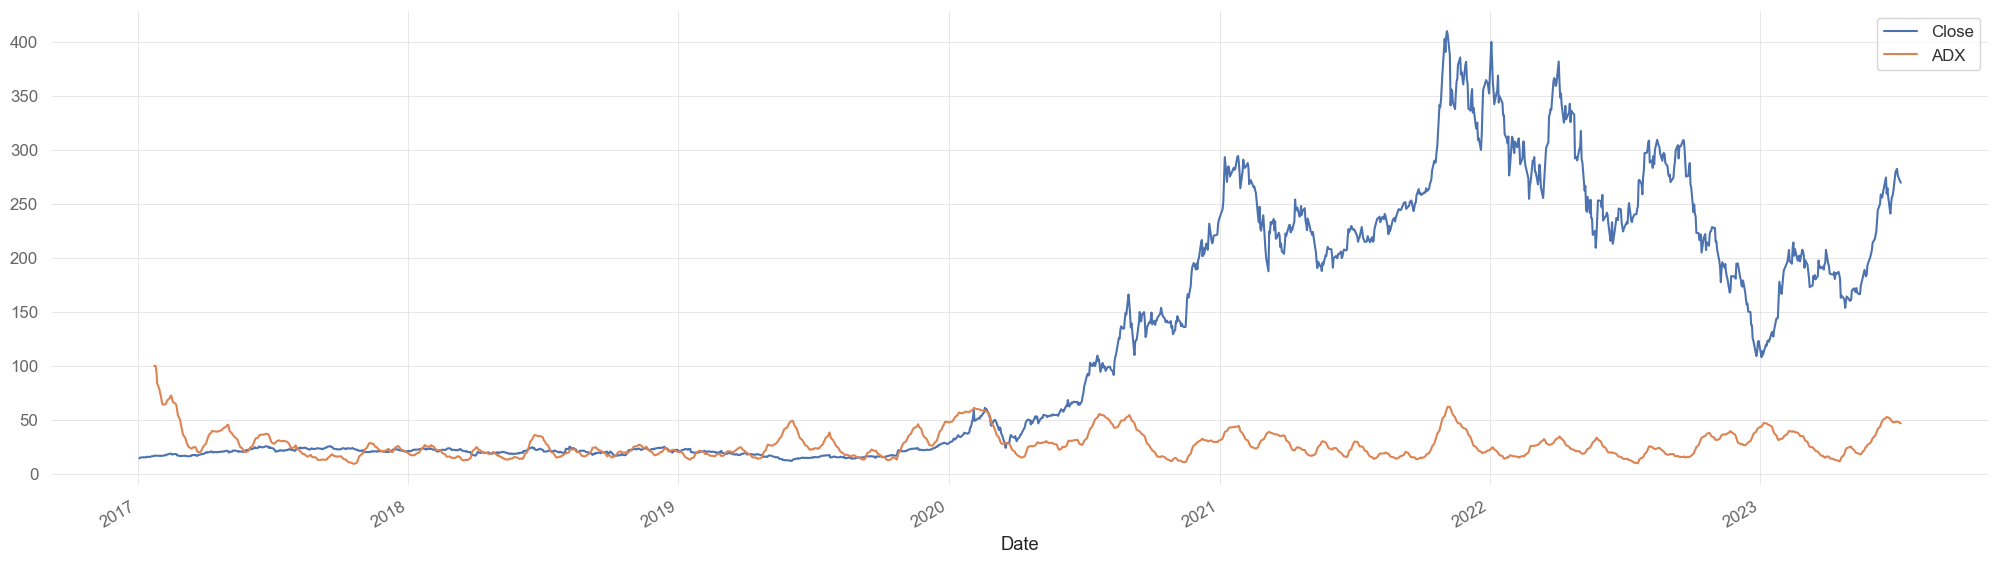

In [10]:
# ADX
df['ADX'] = TA.ADX(df)
df[['Close','ADX']].plot(figsize = (25,7))

<Axes: xlabel='Date'>

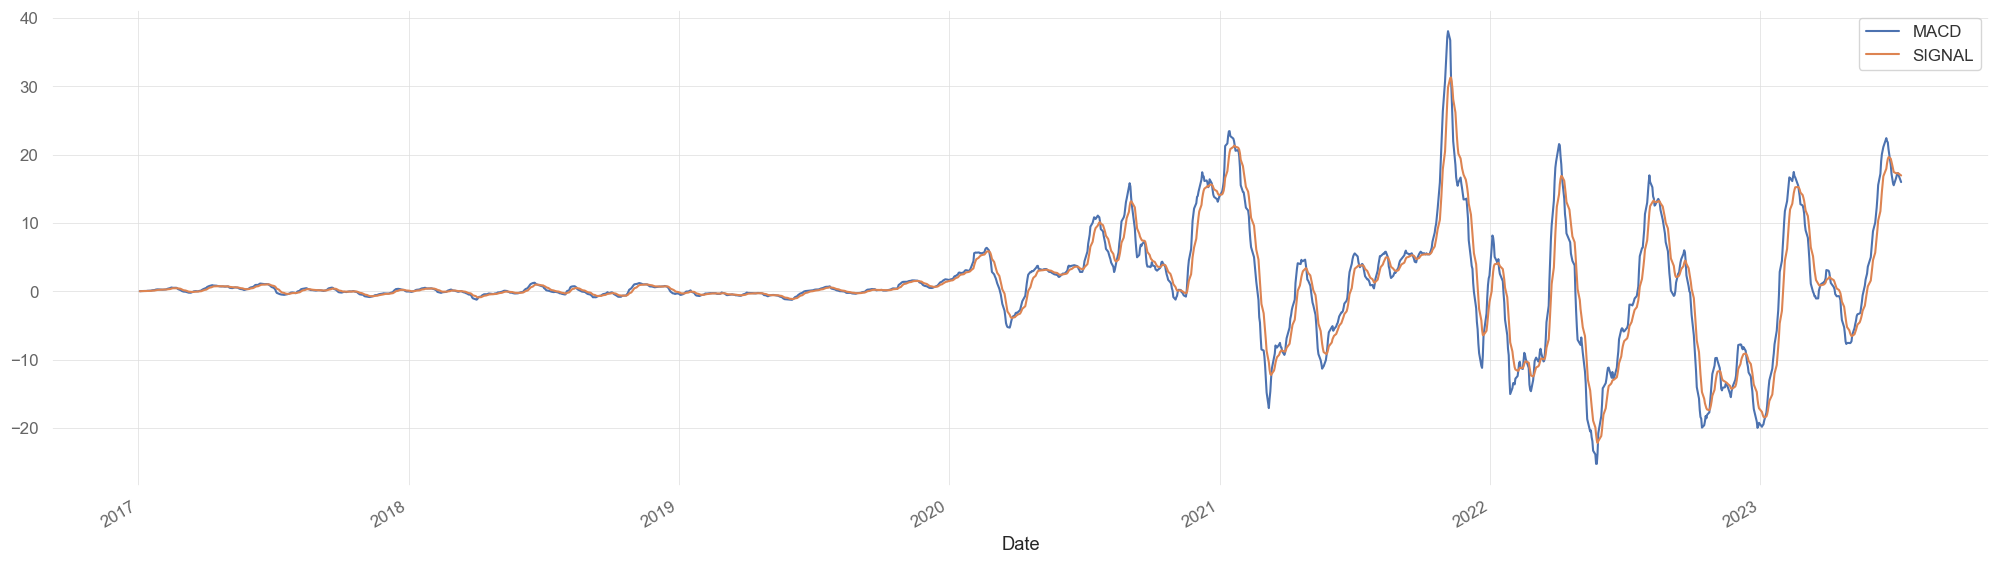

In [11]:
# MACD
df[['MACD', 'SIGNAL']] = TA.MACD(df)

df[['MACD', 'SIGNAL']].plot(figsize = (25,7))


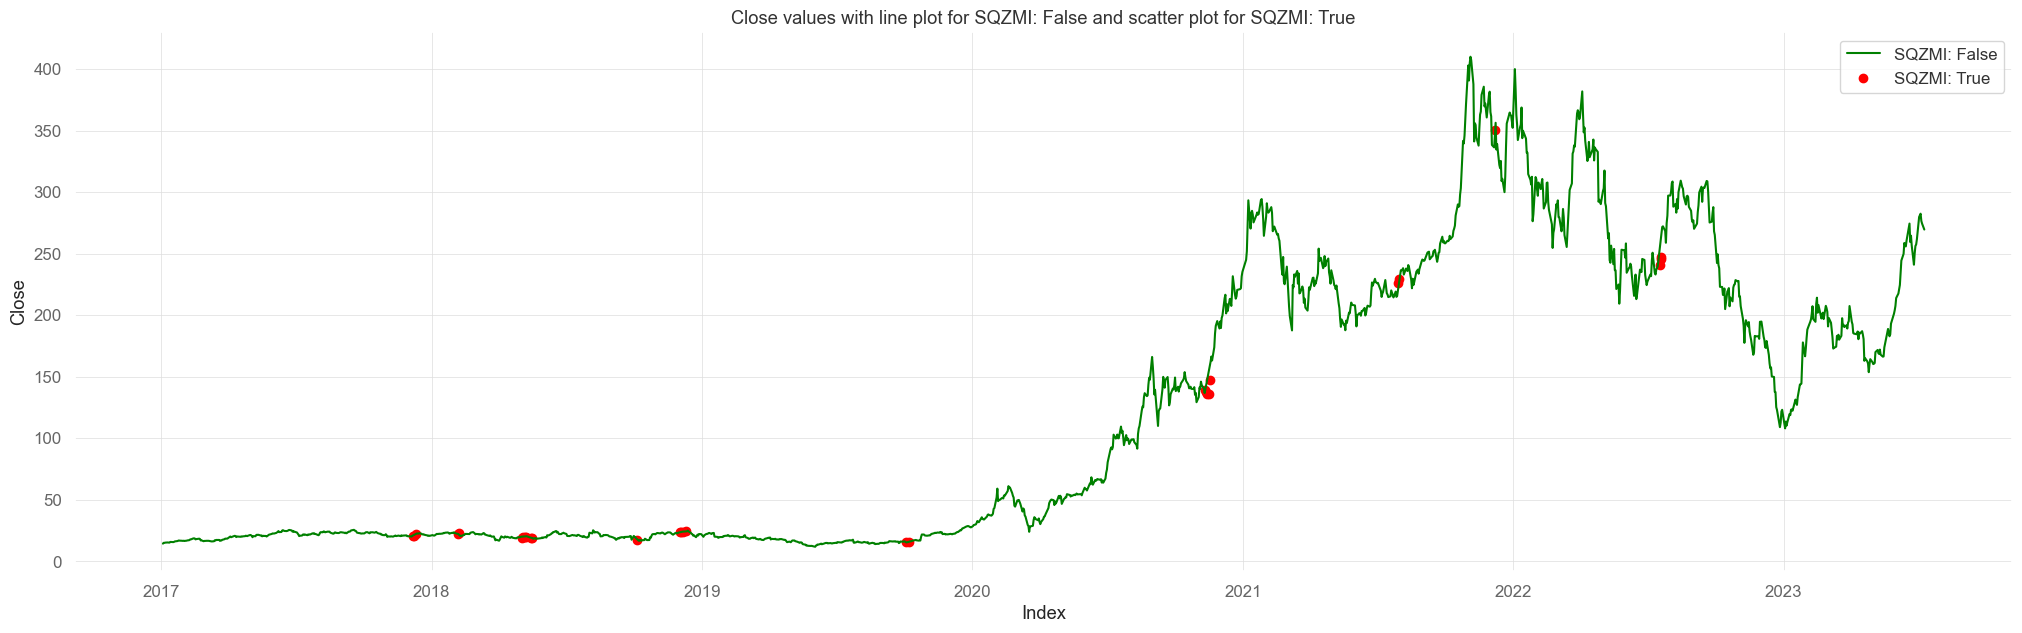

In [12]:
df['SQZMI'] = TA.SQZMI(df)
# Filter the DataFrame based on SQZMI values
false_df = df[df['SQZMI'] == False]
true_df = df[df['SQZMI'] == True]

# Extract the Close values
false_close_values = false_df['Close']
true_close_values = true_df['Close']

# Set the figure size
plt.figure(figsize=(25, 7))  # Adjust the width and height as desired

# Plot the values
plt.plot(false_close_values, color='green', label='SQZMI: False')
plt.scatter(true_df.index, true_close_values, color='red', label='SQZMI: True')
plt.xlabel('Index')
plt.ylabel('Close')
plt.title("Close values with line plot for SQZMI: False and scatter plot for SQZMI: True")
plt.legend()
plt.show()

# 3. Determine trading signals for testable indicators (crossovers, etc.)

# Get data for different intervals

# Iterator Class

In [16]:
# Define a class
class SignalIterator:
    
    def __init__(self, ticker, interval, stocks_df):
        
        if interval == '5m':
            self.sqrt_val = 252 * 78 
        elif interval == '15m':
            self.sqrt_val = 252 * 26  
        elif interval == '30m':
            self.sqrt_val = 252 * 13 
        elif interval == '1h':
            self.sqrt_val = 252 * 6.5
        elif interval == '1d':
            self.sqrt_val = 252
        elif interval == '1wk':
            self.sqrt_val = 52
            
        print(self.sqrt_val)
            
        self.stocks_df = stocks_df
        self.interval = interval
        self.ticker = ticker
        
        # Call the basic methods in the __init__ constructor to be immediately executed
        
        self.get_individual_stock()
        self.indicators()
        self.signals()

    def get_individual_stock(self):
        mask = self.stocks_df.columns.get_level_values(1) == self.ticker
        self.df = self.stocks_df.loc[:, mask]
        self.df.columns = self.df.columns.droplevel(1)
        self.df.dropna(inplace = True, axis = 0)
        
    def indicators(self):
        
        # EMA
        self.df['EMA_10'] = TA.EMA(self.df, 10)
        
        # EMA
        self.df['EMA_20'] = TA.EMA(self.df, 20)
        
         # EMA
        self.df['EMA_50'] = TA.EMA(self.df, 50)
        
        # BBANDS
        self.df[['BB_UPPER','BB_MIDDLE','BB_LOWER']] = TA.BBANDS(self.df, std_multiplier= 3)
        
        # SQZ setup
        self.df['SQZ'] = TA.SQZMI(self.df)
        
        # ADX
        self.df['ADX'] = TA.ADX(self.df)
        self.df['ADX_MEAN'] = self.df['ADX'].rolling(window = 90).mean()
        
        # MACD
        self.df[['MACD', 'SIGNAL']] = TA.MACD(self.df)
        
        # CHAIKIN
        self.df['CHAIKIN'] = TA.CHAIKIN(self.df)
        
        # MFI
        self.df['MFI'] = TA.MFI(self.df)
   
    def signals(self):
        
        ### BUY SIGNALS ###
        
        # EMA Signal logic
        self.df['EMA20_Signal'] = 0.0
        self.df['EMA20_Signal'] = np.where((self.df['Close'] > self.df['EMA_20']), 1.0, 0.0)
        
        # EMA Signal logic
        self.df['EMA50_Signal'] = 0.0
        self.df['EMA50_Signal'] = np.where((self.df['Close'] > self.df['EMA_50']), 1.0, 0.0)
        
        # SQZ Signal logic
        self.df['SQZ_Signal'] = 0.0
        self.df['SQZ_Signal'] = np.where(self.df['SQZ'] == False, 1.0, 0.0)
        
        # ADX Signal logic
        self.df['ADX_Signal'] = 0.0
        self.df['ADX_Signal'] = np.where(self.df['ADX'] > self.df['ADX_MEAN'], 1.0, 0.0)
        
        # MACD Signal logic
        self.df['MACD_Signal'] = 0.0
        self.df['MACD_Signal'] = np.where(self.df['MACD'] > self.df['SIGNAL'], 1.0, 0.0)        
        
        # CHAIKIN Signal logic
        self.df['CHAIKIN_Signal'] = 0.0
        self.df['CHAIKIN_Signal'] = np.where(self.df['CHAIKIN'] > 0, 1.0, 0.0)        
        
        # MFI Signal logic
        self.df['MFI_Signal'] = 0.0
        self.df['MFI_Signal'] = np.where(self.df['MFI'] < 20, 1.0, 0.0)    
        
        ### SELL SIGNALS ###
        
        # BBANDS Sell Signal Logic
        self.df['BB_Sell_Signal'] = 0.0
        self.df['BB_Sell_Signal'] = np.where((self.df['Close'] > self.df['BB_UPPER']), 0.0, 1.0)        
        
    def result(self):
        
        eval_df = pd.DataFrame()
        
        # Define the signal column names
        buy_signal_columns = ['EMA50_Signal','EMA20_Signal','MACD_Signal','SQZ_Signal','CHAIKIN_Signal','MFI_Signal']
        sell_signal_columns = ['BB_Sell_Signal','EMA20_Signal', 'MACD_Signal','ADX_Signal']
        
        # Generate all combinations of signal columns
        for r_buy in range(1, len(buy_signal_columns) + 1):
            combinations_buy = list(itertools.combinations(buy_signal_columns, r_buy))

            # Generate all combinations of sell signal columns
            for r_sell in range(1, len(sell_signal_columns) + 1):
                combinations_sell = list(itertools.combinations(sell_signal_columns, r_sell))

                # Iterate over each combination of buy and sell signals
                for combo_buy in combinations_buy:
                    selected_buy_columns = list(combo_buy)

                    for combo_sell in combinations_sell:
                        selected_sell_columns = list(combo_sell)

                        # Initialize the first row of Main_Signal as 0
                        self.df['Main_Signal'] = 0.0
                        self.df['Portfolio Daily Returns'] = 0.0

                        main_signal = self.df['Main_Signal'].values
                        buy_signal_arr = self.df[selected_buy_columns].values
                        sell_signal_arr = self.df[selected_sell_columns].values
                        close = self.df['Close'].values
                        daily_ret = self.df['Portfolio Daily Returns'].values

                        # Iterate over the remaining rows
                        for i in range(1, self.df.shape[0]):
                            previous_signal = main_signal[i - 1]

                            if previous_signal == 0:
                                # Use Buy Signals to determine current signal
                                buy_signal_conditions = np.all(buy_signal_arr[i] == 1)
                                sell_signal_conditions = np.all(sell_signal_arr[i] == 1)
                                main_signal[i] = int(buy_signal_conditions & sell_signal_conditions)

                                # returns logic
                                daily_ret[i] = 0.0

                            else:
                                # Use Sell Signals to determine current signal
                                sell_signal_conditions = np.all(sell_signal_arr[i] == 1)
                                main_signal[i] = int(sell_signal_conditions)

                                # returns logic
                                previous_price = close[i - 1]
                                current_price = close[i]
                                daily_ret[i] = (current_price - previous_price) / previous_price

                        # Entry/Exit logic
                        self.df['Main_Signal'] = main_signal

                        # Performance Metrics
                        self.df['Entry/Exit'] = self.df['Main_Signal'].diff()
                        self.df['Portfolio Daily Returns'] = daily_ret
                        self.df['Portfolio Cumulative Returns'] = (1 + self.df["Portfolio Daily Returns"]).cumprod()
                        self.df['Buy And Hold Return'] = (1 + self.df['Close'].pct_change()).cumprod()

                        # Create a df with performance summary for each combination

                        # append evaluation metrics to a df as a new row
                        ann_ret =  self.df['Portfolio Daily Returns'].mean() * self.sqrt_val
                        cum_ret = self.df['Portfolio Cumulative Returns'].iloc[-1]
                        ann_volat = self.df['Portfolio Daily Returns'].std() * np.sqrt(self.sqrt_val)
                        sharpe = ann_ret / ann_volat
                        buy_and_hold = self.df['Buy And Hold Return'].iloc[-1]
                        bnh_volatility = self.df['Close'].pct_change().std() * np.sqrt(self.sqrt_val)
                        bnh_sharpe = (self.df['Close'].pct_change().mean()* self.sqrt_val) / bnh_volatility
                        
                        new_row = {'Buy Signals' : f'{selected_buy_columns}',
                                   'Sell Signals' : f'{selected_sell_columns}',
                                   'Algo Annualized Return' : ann_ret,
                                   'Algo Cumulative Return' : cum_ret,
                                   'Algo Annual Volatility' : ann_volat,
                                   'Algo Sharpe Ratio' : sharpe,
                                   'BNH Cumulative Return': buy_and_hold,
                                   'BNH Volatility' : bnh_volatility,
                                   'BNH Sharpe' : bnh_sharpe,
                                   'Ticker': self.ticker}
                        
                        eval_df = eval_df.append(new_row, ignore_index=True)
                        
                        #clear_output(wait=True)
                        #print(f'{selected_buy_columns} & {selected_sell_columns}')

        self.filtered_df = eval_df.sort_values('Algo Cumulative Return', ascending = False)
        return self.filtered_df 

    def plot_top_strategy(self):
        top_5_strategies = self.filtered_df.head()

        # Iterate over each row in the top 5 strategies
        for index, row in top_5_strategies.iterrows():
            # Create a new figure for each strategy
            plt.figure(figsize=(25, 10))

            # Get the strategy name
            ticker = row['Ticker']
            selected_buy_columns = eval(row['Buy Signals'])
            selected_sell_columns = eval(row['Sell Signals'])

            # Initialize the first row of Main_Signal as 0
            self.df['Main_Signal'] = 0.0
            self.df['Portfolio Daily Returns'] = 0.0

            main_signal = self.df['Main_Signal'].values
            buy_signal_arr = self.df[selected_buy_columns].values
            sell_signal_arr = self.df[selected_sell_columns].values
            close = self.df['Close'].values
            daily_ret = self.df['Portfolio Daily Returns'].values

            # Iterate over the remaining rows
            for i in range(1, self.df.shape[0]):
                previous_signal = main_signal[i - 1]

                if previous_signal == 0:
                    # Use Buy Signals to determine current signal
                    buy_signal_conditions = np.all(buy_signal_arr[i] == 1)
                    sell_signal_conditions = np.all(sell_signal_arr[i] == 1)
                    main_signal[i] = int(buy_signal_conditions & sell_signal_conditions)

                    # returns logic
                    daily_ret[i] = 0.0

                else:
                    # Use Sell Signals to determine current signal
                    sell_signal_conditions = np.all(sell_signal_arr[i] == 1)
                    main_signal[i] = int(sell_signal_conditions)

                    # returns logic
                    previous_price = close[i - 1]
                    current_price = close[i]
                    daily_ret[i] = (current_price - previous_price) / previous_price

            # Entry/Exit logic
            self.df['Main_Signal'] = main_signal

            # Performance Metrics
            self.df['Entry/Exit'] = self.df['Main_Signal'].diff()
            self.df['Portfolio Daily Returns'] = daily_ret
            self.df['Portfolio Cumulative Returns'] = (1 + self.df["Portfolio Daily Returns"]).cumprod()
            self.df['Buy And Hold Return'] = (1 + self.df['Close'].pct_change()).cumprod()

            # Create a new figure for each strategy
            plt.figure(figsize=(25, 10))

            # Get the entry/exit signal
            entry_exit = self.df['Entry/Exit']
            bnh = self.df['Buy And Hold Return']
            close = self.df['Close']

            portfolio_cumulative_returns = self.df['Portfolio Cumulative Returns']

            # Plot the portfolio cumulative returns
            plt.plot(bnh, label=f'{self.ticker} Cumulative Return')
            plt.plot(portfolio_cumulative_returns, label='Portfolio Cumulative Returns')

            # Plot the entry points as vertical lines
            for entry_index in entry_exit[entry_exit == 1].index:
                plt.axvline(entry_index, color='g', linestyle='--')

            # Plot the exit points as vertical lines
            for exit_index in entry_exit[entry_exit == -1].index:
                plt.axvline(exit_index, color='r', linestyle='--')

            # Set the plot title and labels
            plt.title(f'Buy: {selected_buy_columns} & Sell: {selected_sell_columns}')
            plt.xlabel("Time")
            plt.ylabel("Price")
            plt.legend()

            # Show the plot for the current strategy
            plt.show()


# Bespoke Strategy

In [17]:
# Define a class
class BespokeStrategy:
    
    def __init__(self, ticker, interval, stocks_df):
        
        if interval == '5m':
            self.sqrt_val = 252 * 78 
        elif interval == '15m':
            self.sqrt_val = 252 * 26  
        elif interval == '30m':
            self.sqrt_val = 252 * 13 
        elif interval == '1h':
            self.sqrt_val = 252 * 6.5
        elif interval == '1d':
            self.sqrt_val = 252
        elif interval == '1wk':
            self.sqrt_val = 52
            
        print(self.sqrt_val)
            
        self.stocks_df = stocks_df
        self.interval = interval
        self.ticker = ticker
        
        # Call the basic methods in the __init__ constructor to be immediately executed
        
        self.get_individual_stock()
        self.indicators()
        self.signals()

    def get_individual_stock(self):
        mask = self.stocks_df.columns.get_level_values(1) == self.ticker
        self.df = self.stocks_df.loc[:, mask]
        self.df.columns = self.df.columns.droplevel(1)
        self.df.dropna(inplace = True, axis = 0)
        
    def indicators(self):
        
        ### SEGMENTATION ###
        
        
        self.df['Returns'] = self.df['Close'].pct_change()
        # <1 means negative return
        seg_window = 21
        self.df['Rolling_Return'] = (1 + self.df['Returns']).rolling(window=seg_window).apply(lambda x: x.prod())
        self.df['Rolling_Volatility'] = self.df['Returns'].rolling(window=seg_window).std() * np.sqrt(self.sqrt_val)
        self.df['Rolling_Sharpe'] = (self.df['Returns'].rolling(window=seg_window).mean() * self.sqrt_val) / self.df['Rolling_Volatility']
        
        ### BUY INDICATORS ###
        
        # MACD
        self.df[['MACD', 'SIGNAL']] = TA.MACD(self.df)
        
        # SQZ
        self.df['SQZ'] = TA.SQZMI(self.df)
        
        ### SELL INDICATORS ###
        
        # BBANDS
        self.df[['BB_UPPER','BB_MIDDLE','BB_LOWER']] = TA.BBANDS(self.df, std_multiplier= 3)
        
        # EMA
        self.df['EMA_20'] = TA.EMA(self.df, 20)
        
        # EMA
        self.df['EMA_50'] = TA.EMA(self.df, 50)
        
        # ADX
        self.df['ADX'] = TA.ADX(self.df)
        self.df['ADX_MEAN'] = self.df['ADX'].rolling(window = 90).mean()
        
   
    def signals(self):
        
        ### SEGMENTATION ###
        
        self.df['Sharpe_Signal'] = 0.0
        self.df['Sharpe_Signal'] = np.where(self.df['Rolling_Sharpe'] > 1, 1.0, 0.0)  
        
        self.df['Return_Signal'] = 0.0
        self.df['Return_Signal'] = np.where(self.df['Rolling_Return'] > 1.2, 1.0, 0.0)  
        
        
        ### BUY SIGNALS ###
        
        # EMA Signal logic
        self.df['EMA20_Signal'] = 0.0
        self.df['EMA20_Signal'] = np.where(self.df['Close'] > self.df['EMA_20'], 1.0, 0.0)      
        
        # SQZ Signal logic
        self.df['SQZ_Signal'] = 0.0
        self.df['SQZ_Signal'] = np.where(self.df['SQZ'] == True, 1.0, 0.0)
        
        # MACD Signal logic
        self.df['MACD_Signal'] = 0.0
        self.df['MACD_Signal'] = np.where(self.df['MACD'] > self.df['SIGNAL'], 1.0, 0.0) 
        
        ### SELL SIGNALS ### 
        
        # EMA Signal logic
        self.df['EMA50_Signal'] = 0.0
        self.df['EMA50_Signal'] = np.where((self.df['Close'] > self.df['EMA_50']), 1.0, 0.0)        
        
        # BBANDS Sell Signal Logic
        self.df['BB_Sell_Signal'] = 0.0
        self.df['BB_Sell_Signal'] = np.where((self.df['Close'] > self.df['BB_UPPER']), 0.0, 1.0)  
        
        # ADX Signal logic
        self.df['ADX_Signal'] = 0.0
        self.df['ADX_Signal'] = np.where(self.df['ADX'] > self.df['ADX_MEAN'], 1.0, 0.0)
        
    def result(self):
        
        self.eval_df = pd.DataFrame()
        
        # Define the signal column names
        buy_signal_columns = ['Return_Signal']
        sell_signal_columns = ['EMA20_Signal']
        
        # Initialize the first row of Main_Signal as 0
        self.df['Main_Signal'] = 0.0
        self.df['Portfolio Daily Returns'] = 0.0
        
        main_signal = self.df['Main_Signal'].values
        buy_signal_arr = self.df[buy_signal_columns].values
        sell_signal_arr = self.df[sell_signal_columns].values
        close = self.df['Close'].values
        daily_ret = self.df['Portfolio Daily Returns'].values
        
        # Iterate over the remaining rows
        for i in range(1, self.df.shape[0]):
            previous_signal = main_signal[i - 1]
            
            if previous_signal == 0:
                # Use Buy Signals to determine current signal
                buy_signal_conditions = np.all(buy_signal_arr[i] == 1)
                sell_signal_conditions = np.all(sell_signal_arr[i] == 1)
                main_signal[i] = int(buy_signal_conditions & sell_signal_conditions)
                
                # returns logic
                daily_ret[i] = 0.0
                
            else:
                # Use Sell Signals to determine current signal
                sell_signal_conditions = np.all(sell_signal_arr[i] == 1)
                main_signal[i] = int(sell_signal_conditions)
                
                # returns logic
                previous_price = close[i - 1]
                current_price = close[i]
                daily_ret[i] = (current_price - previous_price) / previous_price
                
        # Entry/Exit logic
        self.df['Main_Signal'] = main_signal

        # Performance Metrics
        self.df['Entry/Exit'] = self.df['Main_Signal'].diff()
        self.df['Portfolio Daily Returns'] = daily_ret
        self.df['Portfolio Cumulative Returns'] = (1 + self.df["Portfolio Daily Returns"]).cumprod()
        self.df['Buy And Hold Return'] = (1 + self.df['Close'].pct_change()).cumprod()

        # Create a df with performance summary for each combination

        # append evaluation metrics to a df as a new row
        ann_ret =  self.df['Portfolio Daily Returns'].mean() * self.sqrt_val
        cum_ret = self.df['Portfolio Cumulative Returns'].iloc[-1]
        ann_volat = self.df['Portfolio Daily Returns'].std() * np.sqrt(self.sqrt_val)
        sharpe = ann_ret / ann_volat
        buy_and_hold = self.df['Buy And Hold Return'].iloc[-1]
        bnh_volatility = self.df['Close'].pct_change().std() * np.sqrt(self.sqrt_val)
        bnh_sharpe = (self.df['Close'].pct_change().mean()* self.sqrt_val) / bnh_volatility

        new_row = {'Buy Signals' : f'{buy_signal_columns}',
                   'Sell Signals' : f'{sell_signal_columns}',
                   'Algo Annualized Return' : ann_ret,
                   'Algo Cumulative Return' : cum_ret,
                   'Algo Annual Volatility' : ann_volat,
                   'Algo Sharpe Ratio' : sharpe,
                   'BNH Cumulative Return': buy_and_hold,
                   'BNH Volatility' : bnh_volatility,
                   'BNH Sharpe' : bnh_sharpe,
                   'Ticker': self.ticker}
        
        self.eval_df = self.eval_df.append(new_row, ignore_index=True)
        
        return self.eval_df

    def plot_strategy(self):

        # Create a new figure for each strategy
        plt.figure(figsize=(25, 10))
        
        # Get the entry/exit signal
        entry_exit = self.df['Entry/Exit']
        bnh = self.df['Buy And Hold Return']
        close = self.df['Close']
        #rolling_sharpe = self.df['Rolling_Sharpe']
        
        portfolio_cumulative_returns = self.df['Portfolio Cumulative Returns']
        
        # Plot the portfolio cumulative returns
        plt.plot(bnh, label=f'{self.ticker} Cumulative Return')
        plt.plot(portfolio_cumulative_returns, label='Portfolio Cumulative Returns')
        #plt.plot(rolling_sharpe, label='Rolling Sharpe')
        
        # Plot the entry points as vertical lines
        for entry_index in entry_exit[entry_exit == 1].index:
            plt.axvline(entry_index, color='g', linestyle='--')

        # Plot the exit points as vertical lines
        for exit_index in entry_exit[entry_exit == -1].index:
            plt.axvline(exit_index, color='r', linestyle='--')

        # Set the plot title and labels
        plt.title("Strategy - Entry/Exits")
        plt.xlabel("Time")
        plt.ylabel("Return")
        plt.legend()

        # Show the plot for the current strategy
        plt.show()


# Tester Class

In [18]:
# class to test different strategies            
class Tester:
    
    def __init__(self, interval, stocks_df, stock_list):
        
        self.stock_list = stock_list
        self.interval = interval
        self.stocks_data = stocks_df
        
        
        self.backtest_on_stocks()
        self.top_return()
        self.top_sharpe()
        
    def backtest_on_stocks(self):
        self.combined = pd.DataFrame()
        for index, stock in enumerate(self.stock_list):
            self.iterator = SignalIterator(stock, interval = self.interval, stocks_df = self.stocks_data)
            result = self.iterator.result()
            self.combined = pd.concat([self.combined, result], axis=0)
            clear_output(wait=True)
            print(f'{stock} analysis complete ({index+1}/{len(self.stock_list)})')
    
    def top_return(self):
        return self.combined.sort_values('Algo Cumulative Return', ascending= False).head(15)
    
    def top_sharpe(self):
        return self.combined.sort_values('Algo Sharpe Ratio', ascending= False).head(15)
    
    def full(self):
        return self.combined

In [19]:
tester_demo = Tester(stocks_df= stocks_1d, interval = '1d', stock_list= ['TSLA'])

TSLA analysis complete (1/1)


In [20]:
tester_demo.top_sharpe()

Buy Signals  \
27                                                ['EMA50_Signal']   
398                ['EMA50_Signal', 'EMA20_Signal', 'MACD_Signal']   
153                               ['EMA50_Signal', 'EMA20_Signal']   
159                                ['EMA50_Signal', 'MACD_Signal']   
60                                                ['EMA50_Signal']   
240                               ['EMA50_Signal', 'EMA20_Signal']   
515                ['EMA50_Signal', 'EMA20_Signal', 'MACD_Signal']   
244                                ['EMA50_Signal', 'MACD_Signal']   
96                                 ['EMA50_Signal', 'MACD_Signal']   
2                                                 ['EMA50_Signal']   
92                                ['EMA50_Signal', 'EMA20_Signal']   
317                ['EMA50_Signal', 'EMA20_Signal', 'MACD_Signal']   
165                                 ['EMA50_Signal', 'SQZ_Signal']   
422                  ['EMA50_Signal', 'MACD_Signal', 'SQZ_Signal']   
678  ['EMA50_Signal', 'EMA20_Signal', 'MACD_Signal', 'SQZ_Signal']   

                                          Sell Signals  \
27                     ['EMA20_Signal', 'MACD_Signal']   
398                    ['EMA20_Signal', 'MACD_Signal']   
153                    ['EMA20_Signal', 'MACD_Signal']   
159                    ['EMA20_Signal', 'MACD_Signal']   
60   ['BB_Sell_Signal', 'EMA20_Signal', 'MACD_Signal']   
240  ['BB_Sell_Signal', 'EMA20_Signal', 'MACD_Signal']   
515  ['BB_Sell_Signal', 'EMA20_Signal', 'MACD_Signal']   
244  ['BB_Sell_Signal', 'EMA20_Signal', 'MACD_Signal']   
96                                     ['MACD_Signal']   
2                                      ['MACD_Signal']   
92                                     ['MACD_Signal']   
317                                    ['MACD_Signal']   
165                    ['EMA20_Signal', 'MACD_Signal']   
422                    ['EMA20_Signal', 'MACD_Signal']   
678                    ['EMA20_Signal', 'MACD_Signal']   

     Algo Annualized Return  Algo Cumulative Return  Algo Annual Volatility  \
27                 0.497133               16.212186                0.372885   
398                0.497133               16.212186                0.372885   
153                0.497133               16.212186                0.372885   
159                0.497133               16.212186                0.372885   
60                 0.479252               14.877924                0.360590   
240                0.479252               14.877924                0.360590   
515                0.479252               14.877924                0.360590   
244                0.479252               14.877924                0.360590   
96                 0.485809               14.665322                0.384224   
2                  0.485809               14.665322                0.384224   
92                 0.485809               14.665322                0.384224   
317                0.485809               14.665322                0.384224   
165                0.468006               13.497706                0.370321   
422                0.468006               13.497706                0.370321   
678                0.468006               13.497706                0.370321   

     Algo Sharpe Ratio  BNH Cumulative Return  BNH Volatility  BNH Sharpe  \
27            1.333208              18.637494        0.613809    1.039894   
398           1.333208              18.637494        0.613809    1.039894   
153           1.333208              18.637494        0.613809    1.039894   
159           1.333208              18.637494        0.613809    1.039894   
60            1.329078              18.637494        0.613809    1.039894   
240           1.329078              18.637494        0.613809    1.039894   
515           1.329078              18.637494        0.613809    1.039894   
244           1.329078              18.637494        0.613809    1.039894   
96            1.264390              18.637494  

In [21]:
tester_demo.top_return()

Buy Signals  \
1                                                 ['EMA50_Signal']   
91                                ['EMA50_Signal', 'EMA20_Signal']   
0                                                 ['EMA50_Signal']   
114                                 ['EMA20_Signal', 'SQZ_Signal']   
110                                ['EMA20_Signal', 'MACD_Signal']   
94                                 ['EMA50_Signal', 'MACD_Signal']   
98                                  ['EMA50_Signal', 'SQZ_Signal']   
8                                                  ['MACD_Signal']   
90                                ['EMA50_Signal', 'EMA20_Signal']   
4                                                 ['EMA20_Signal']   
12                                                  ['SQZ_Signal']   
355                  ['EMA20_Signal', 'MACD_Signal', 'SQZ_Signal']   
615  ['EMA50_Signal', 'EMA20_Signal', 'MACD_Signal', 'SQZ_Signal']   
319                 ['EMA50_Signal', 'EMA20_Signal', 'SQZ_Signal']   
315                ['EMA50_Signal', 'EMA20_Signal', 'MACD_Signal']   

           Sell Signals  Algo Annualized Return  Algo Cumulative Return  \
1      ['EMA20_Signal']                0.531688               17.781597   
91     ['EMA20_Signal']                0.531688               17.781597   
0    ['BB_Sell_Signal']                0.615771               16.656896   
114  ['BB_Sell_Signal']                0.615771               16.656896   
110  ['BB_Sell_Signal']                0.615771               16.656896   
94   ['BB_Sell_Signal']                0.615771               16.656896   
98   ['BB_Sell_Signal']                0.615771               16.656896   
8    ['BB_Sell_Signal']                0.615771               16.656896   
90   ['BB_Sell_Signal']                0.615771               16.656896   
4    ['BB_Sell_Signal']                0.615771               16.656896   
12   ['BB_Sell_Signal']                0.615771               16.656896   
355  ['BB_Sell_Signal']                0.615771               16.656896   
615  ['BB_Sell_Signal']                0.615771               16.656896   
319  ['BB_Sell_Signal']                0.615771               16.656896   
315  ['BB_Sell_Signal']                0.615771               16.656896   

     Algo Annual Volatility  Algo Sharpe Ratio  BNH Cumulative Return  \
1                  0.422313           1.258991              18.637494   
91                 0.422313           1.258991              18.637494   
0                  0.605951           1.016207              18.637494   
114                0.605951           1.016207              18.637494   
110                0.605951           1.016207              18.637494   
94                 0.605951           1.016207              18.637494   
98                 0.605951           1.016207              18.637494   
8                  0.605951           1.016207              18.637494   
90                 0.605951           1.016207              18.637494   
4                  0.605951           1.016207              18.637494   
12                 0.605951           1.016207              18.637494   
355                0.605951           1.016207              18.637494   
615                0.605951           1.016207              18.637494   
319                0.605951           1.016207              18.637494   
315                0.605951           1.016207              18.637494   

     BNH Volatility  BNH Sharpe Ticker  
1          0.613809    1.039894   TSLA  
91         0.613809    1.039894   TSLA  
0          0.613809    1.039894   TSLA  
114        0.613809    1.039894   TSLA  
110        0.613809    1.039894   TSLA  
94         0.613809    1.039894   TSLA  
98         0.613809    1.039894   TSLA  
8          0.613809    1.039894   TSLA  
90         0.613809    1.039894   TSLA  
4          0.613809    1.039894   TSLA  
12         0.613809    1.039894   TSLA  
355        0.613809    1.039894   TSLA  
615        0.613809    1.039894

In [22]:
tester_demo.full()

Buy Signals  \
1                                                                                 ['EMA50_Signal']   
91                                                                ['EMA50_Signal', 'EMA20_Signal']   
0                                                                                 ['EMA50_Signal']   
12                                                                                  ['SQZ_Signal']   
319                                                 ['EMA50_Signal', 'EMA20_Signal', 'SQZ_Signal']   
..                                                                                             ...   
509                                                 ['SQZ_Signal', 'CHAIKIN_Signal', 'MFI_Signal']   
508                                                ['MACD_Signal', 'CHAIKIN_Signal', 'MFI_Signal']   
507                                                ['MACD_Signal', 'CHAIKIN_Signal', 'MFI_Signal']   
506                                                ['MACD_Signal', 'CHAIKIN_Signal', 'MFI_Signal']   
944  ['EMA50_Signal', 'EMA20_Signal', 'MACD_Signal', 'SQZ_Signal', 'CHAIKIN_Signal', 'MFI_Signal']   

                                                        Sell Signals  \
1                                                   ['EMA20_Signal']   
91                                                  ['EMA20_Signal']   
0                                                 ['BB_Sell_Signal']   
12                                                ['BB_Sell_Signal']   
319                                               ['BB_Sell_Signal']   
..                                                               ...   
509                               ['BB_Sell_Signal', 'EMA20_Signal']   
508                                    ['MACD_Signal', 'ADX_Signal']   
507                                   ['EMA20_Signal', 'ADX_Signal']   
506                                  ['EMA20_Signal', 'MACD_Signal']   
944  ['BB_Sell_Signal', 'EMA20_Signal', 'MACD_Signal', 'ADX_Signal']   

     Algo Annualized Return  Algo Cumulative Return  Algo Annual Volatility  \
1                  0.531688               17.781597                0.422313   
91                 0.531688               17.781597                0.422313   
0                  0.615771               16.656896                0.605951   
12                 0.615771               16.656896                0.605951   
319                0.615771               16.656896                0.605951   
..                      ...                     ...                     ...   
509                0.000000                1.000000                0.000000   
508                0.000000                1.000000                0.000000   
507                0.000000                1.000000                0.000000   
506                0.000000                1.000000                0.000000   
944                0.000000                1.000000                0.000000   

     Algo Sharpe Ratio  BNH Cumulative Return  BNH Volatility  BNH Sharpe  \
1             1.258991              18.637494        0.613809    1.039894   
91            1.258991              18.637494        0.613809    1.039894   
0             1.016207              18.637494        0.613809    1.039894   
12            1.016207              18.637494        0.613809    1.039894   
319           1.016207              18.637494        0.613809    1.039894   
..                 ...                    ...             ...         ...   
509                NaN              18.637494        0.613809    1.039894   
508                NaN              18.637494        0.613809    1.039894   
507                NaN              18.637494        0.613809    1.039894   
506                NaN              18.637494        0.613809    1.039894   
944                NaN              18.637494        0.613809    1.039894   

    Ticker  
1     TSLA  
91    TSLA  
0     TSLA  
12    TSLA  
319   TSLA  
..     ...  
509   TSLA  
508   TSLA  
507   

In [23]:
tailored_strategy = BespokeStrategy('TSLA', '1d', stocks_1d )
tailored_strategy.result()

252


Buy Signals      Sell Signals  Algo Annualized Return  \
0  ['Return_Signal']  ['EMA20_Signal']                0.327805   

   Algo Cumulative Return  Algo Annual Volatility  Algo Sharpe Ratio  \
0                5.751928                0.342473            0.95717   

   BNH Cumulative Return  BNH Volatility  BNH Sharpe Ticker  
0              18.637494        0.613809    1.039894   TSLA

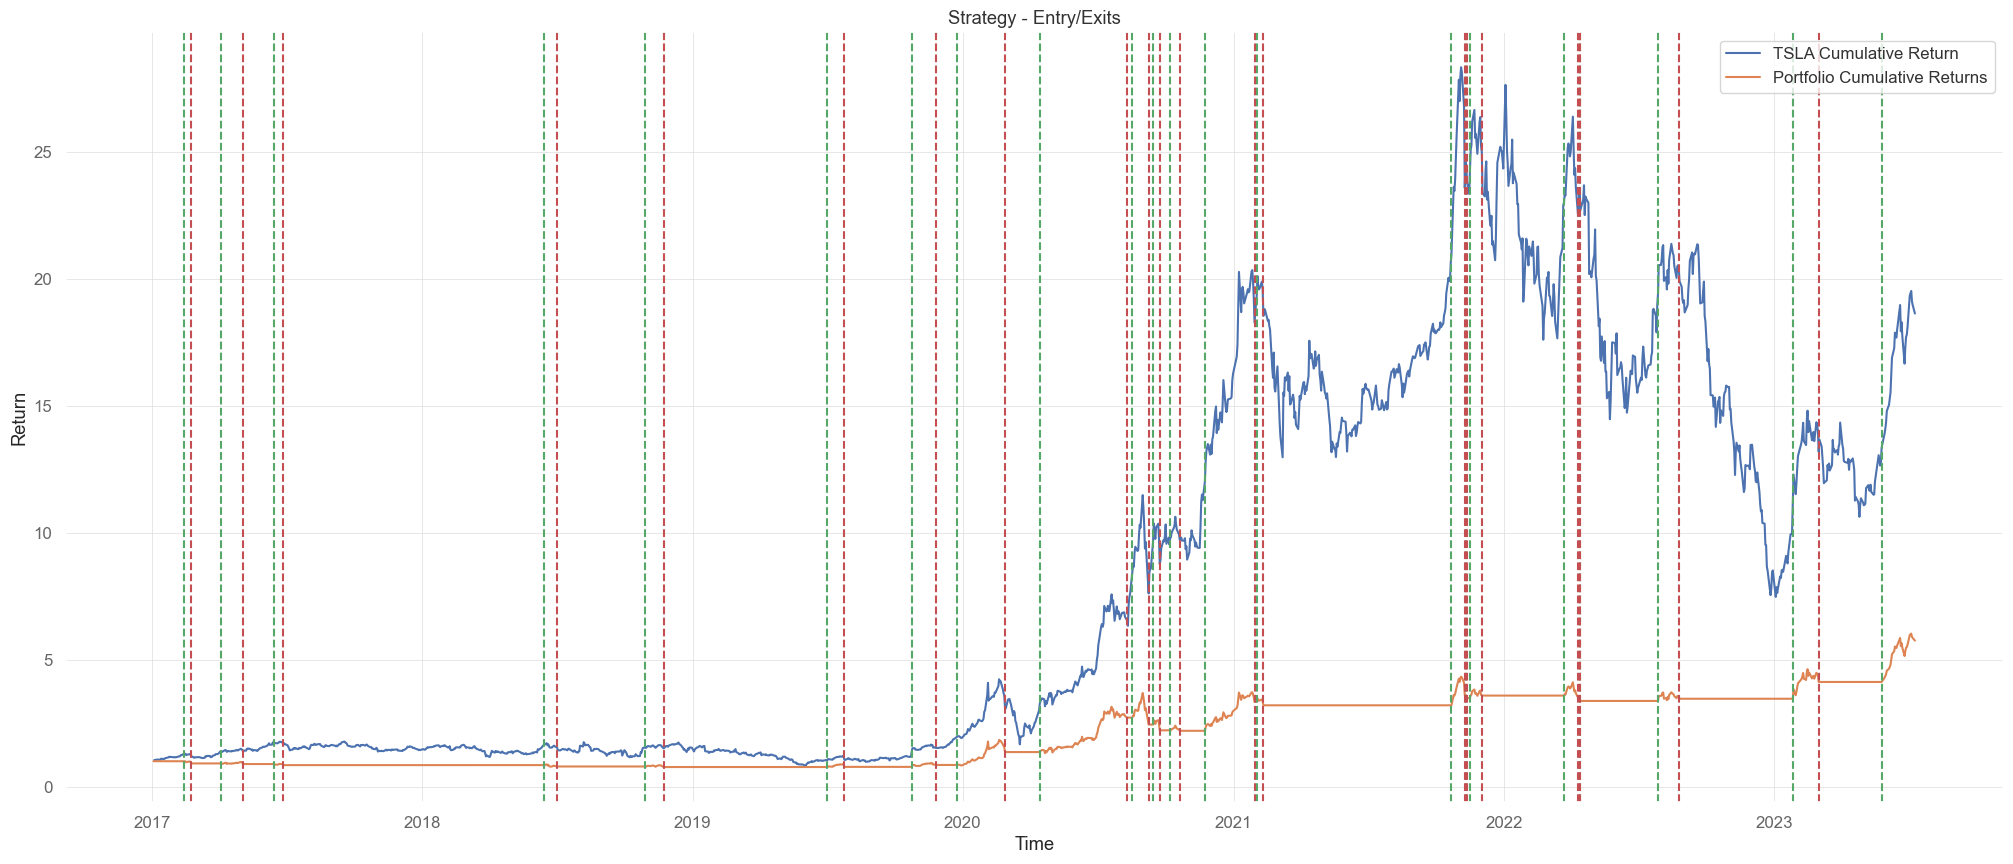

In [24]:
tailored_strategy.plot_strategy()

In [25]:
tester_all = Tester(stocks_df= stocks_1d, interval = '1d', stock_list= stock_names)

ABBV analysis complete (3/95)
252


KeyboardInterrupt: 

In [ ]:
tester_all.top_return()

In [ ]:
tester_all.top_sharpe()

In [ ]:
full_df = tester_all.full()
full_df

In [ ]:
# next step
# Rank order by Sharpe Ratios 33 33 33 
# Run top 5 algos on 3 groups 